In [12]:
import os
import numpy as np

from keras.activations import relu
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, Flatten, Conv1D, MaxPooling1D
from keras.layers import concatenate
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report

from IPython.display import SVG

# Utils functions

In [13]:
def compute_metrics(raw_predictions, label_encoder):
    # convert raw predictions to class indexes
    threshold = 0.5
    class_predictions = [(x > threshold).astype(int) for x in model.predict(x_test)]

    # convert raw predictions to class indexes
    threshold = 0.5
    class_predictions = [(x > threshold).astype(int) for x in model.predict(x_test)]

    # select only one class (i.e., the dim in the vector with 1.0 all other are at 0.0)
    class_index = ([np.argmax(x) for x in class_predictions])

    # convert back to original class names
    pred_classes = label_encoder.inverse_transform(class_index)

    # print precision, recall, f1-score report
    print(classification_report(y_test, pred_classes))

def load_embeddings():
    glove_dir = '/Users/dsbatista/resources/glove.6B'

    embeddings_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))

    return embeddings_index


def create_embeddings_matrix(embeddings_index, vocab_size, embedding_dim=100):
    embeddings_matrix = np.random.rand(vocab_size, embedding_dim)
    for i, word in enumerate(embeddings_index):
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embeddings_matrix[i] = embedding_vector
    print('Matrix shape: {}'.format(embeddings_matrix.shape))
    return embeddings_matrix

def get_embeddings_layer(embeddings_matrix, name, max_len, trainable=False):
    embedding_layer = Embedding(
        input_dim=embeddings_matrix.shape[0],
        output_dim=embeddings_matrix.shape[1],
        input_length=max_len,
        weights=[embeddings_matrix],
        trainable=trainable,
        name=name)
    return embedding_layer

def get_conv_pool(x_input, sufix, n_grams=[3,4,5], feature_maps=100):
    branches = []
    for n in n_grams:
        branch = Conv1D(filters=feature_maps, kernel_size=n, activation=relu, name='Conv_'+sufix+'_'+str(n))(x_input)
        branch = MaxPooling1D(pool_size=2, strides=None, padding='valid', name='MaxPooling_'+sufix+'_'+str(n))(branch)
        branch = Flatten(name='Flatten_'+sufix+'_'+str(n))(branch)
        branches.append(branch)
    return branches

# Convolutional Neural Networks for Sentence Classification (Kim, 2014)
https://arxiv.org/pdf/1408.5882.pdf

## 3.1 Hyperparameters and Training

For all datasets we use: 

- rectified linear units;
- filterwindows (h) of 3, 4, 5 with 100 feature maps each;
- dropout rate (p) of 0.5;
- l2 constraint (s) of 3;
- mini-batch size of 50;

These values were chosen via a grid search on the SST-2 dev set. 

We do not otherwise perform any dataset specific tuning other than early stopping on dev sets. For datasets without a standard dev set we randomly select 10% of the training data as the dev set. 

Training is done through stochastic gradient descent over shuffled mini-batches with the Adadelta update rule (Zeiler, 2012).

## 3.2 Pre-trained Word Vectors

We use the publicly available:

- word2vec vectors that were trained on 100 billion words from Google News.
- Words not present in the set of pre-trained words are initialized randomly.

## 3.3 Models Variations

## 1) `CNN-rand`: all words are randomly initialized and then modified during training

In [14]:
def get_cnn_rand(embedding_dim=100, vocab_size=1000, max_len=50):
    # create the embedding layer
    embedding_matrix = np.random.rand(vocab_size, embedding_dim)
    embedding_layer = get_embeddings_layer(embedding_matrix, 'embedding_layer_dynamic', max_len, trainable=True)

    # connect the input with the embedding layer
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)

    # generate several branches in the network, each for a different convolution+pooling operation,
    # and concatenate the result of each branch into a single vector
    branches = get_conv_pool(x, 'dynamic')
    z = concatenate(branches, axis=-1)

    # pass the concatenated vector to the predition layer
    o = Dense(1, activation='sigmoid', name='output')(z)

    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': 'binary_crossentropy'}, optimizer='adam')

    return model

In [15]:
model_1 = get_cnn_rand()

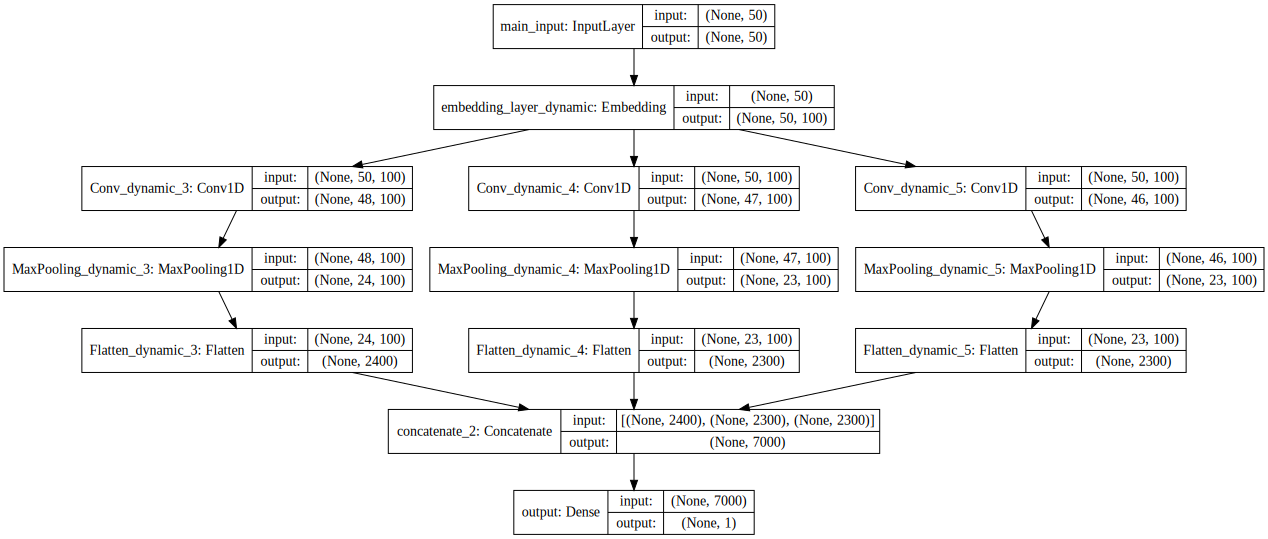

In [16]:
SVG(model_to_dot(model_1, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

## 2) CNN-static: pre-trained vectors with all the words— including the unknown ones that are randomly initialized—kept static and only the other parameters of the model are learned

In [17]:
embeddings_index = load_embeddings()

Found 400000 word vectors.


In [18]:
embeddings_matrix = create_embeddings_matrix(embeddings_index, 1000, 100)

Matrix shape: (1000, 100)


In [20]:
embedding_layer = get_embeddings_layer(embeddings_matrix, 'embedding_layer_static', 55, trainable=False)

In [21]:
def get_cnn_pre_trained_embeddings(embedding_layer, max_len):
    # connect the input with the embedding layer
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)

    # generate several branches in the network, each for a different convolution+pooling operation,
    # and concatenate the result of each branch into a single vector
    branches = get_conv_pool(x, 'static')
    z = concatenate(branches, axis=-1)

    # pass the concatenated vector to the predition layer
    o = Dense(1, activation='sigmoid', name='output')(z)

    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': 'binary_crossentropy'}, optimizer='adam')

    return model

In [22]:
model = get_cnn_pre_trained_embeddings(embedding_layer, 55)

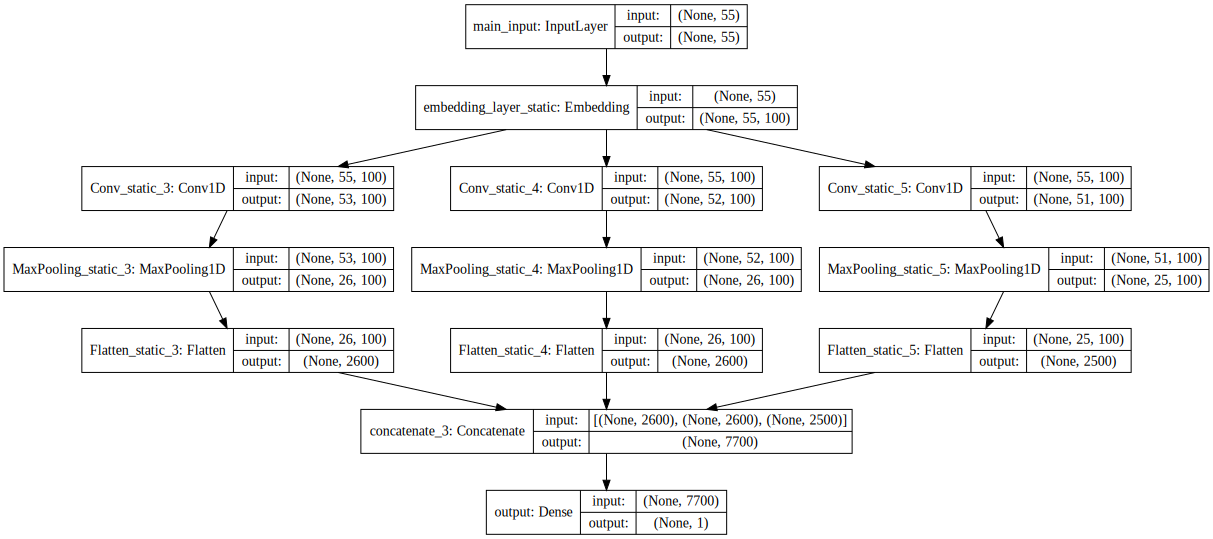

In [23]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

## 3) Same as above but word vectors are fine-tuned

In [29]:
embedding_layer = get_embeddings_layer(embeddings_matrix, 'embedding_layer_dynamic', 55, trainable=True)
model = get_cnn_pre_trained_embeddings(embedding_layer, 55)

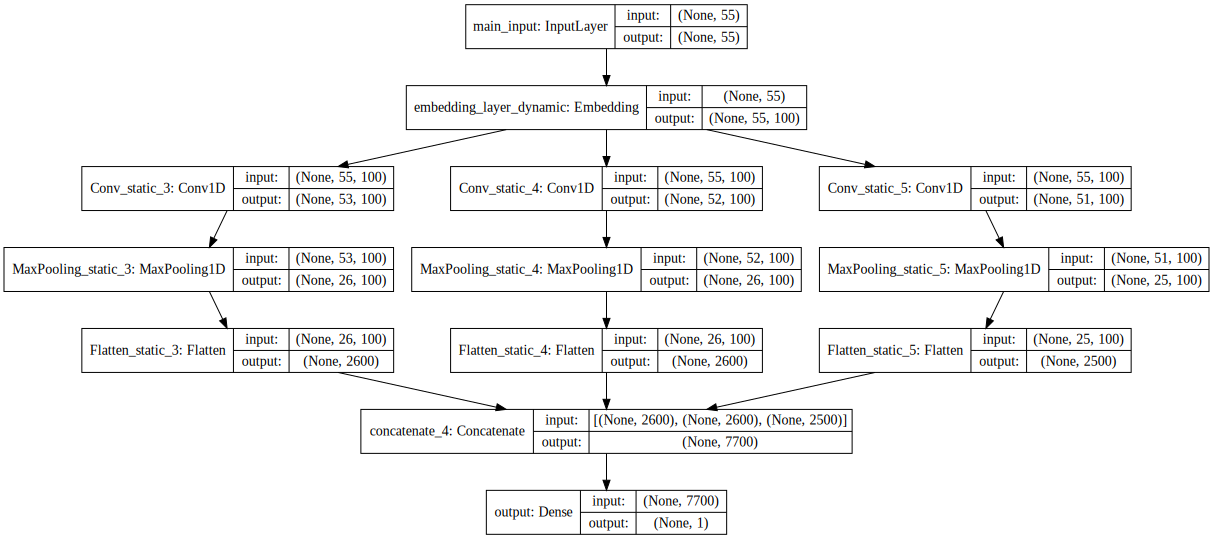

In [30]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))


## 4) CNN-multichannel: A model with two sets of word vectors. Each set of vectors is treated as a `channel` and each filter is applied

In [38]:
embedding_layer_channel_1 = get_embeddings_layer(embeddings_matrix, 'embedding_layer_dynamic', 55, trainable=True)
embedding_layer_channel_2 = get_embeddings_layer(embeddings_matrix, 'embedding_layer_static', 55, trainable=False)

def get_cnn_multichannel(embedding_layer_channel_1, embedding_layer_channel_2, max_len):

    # dynamic channel
    input_dynamic = Input(shape=(max_len,), dtype='int32', name='input_dynamic')
    x = embedding_layer_channel_1(input_dynamic)
    branches_dynamic = get_conv_pool(x, 'static')
    z_dynamic = concatenate(branches_dynamic, axis=-1)

    # static channel
    input_static = Input(shape=(max_len,), dtype='int32', name='input_static')
    x = embedding_layer_channel_2(input_static)
    branches_static = get_conv_pool(x, 'dynamic')
    z_static = concatenate(branches_static, axis=-1)

    # concatenate both models and pass to classification layer
    z = concatenate([z_static,z_dynamic], axis=-1)

    # pass the concatenated vector to the predition layer
    o = Dense(6, activation='sigmoid', name='output')(z)

    model = Model(inputs=[input_static, input_dynamic], outputs=o)
    model.compile(loss={'output': 'binary_crossentropy'}, optimizer='adam')

    return model

In [39]:
model = get_cnn_multichannel(embedding_layer_channel_1, embedding_layer_channel_2, 55)

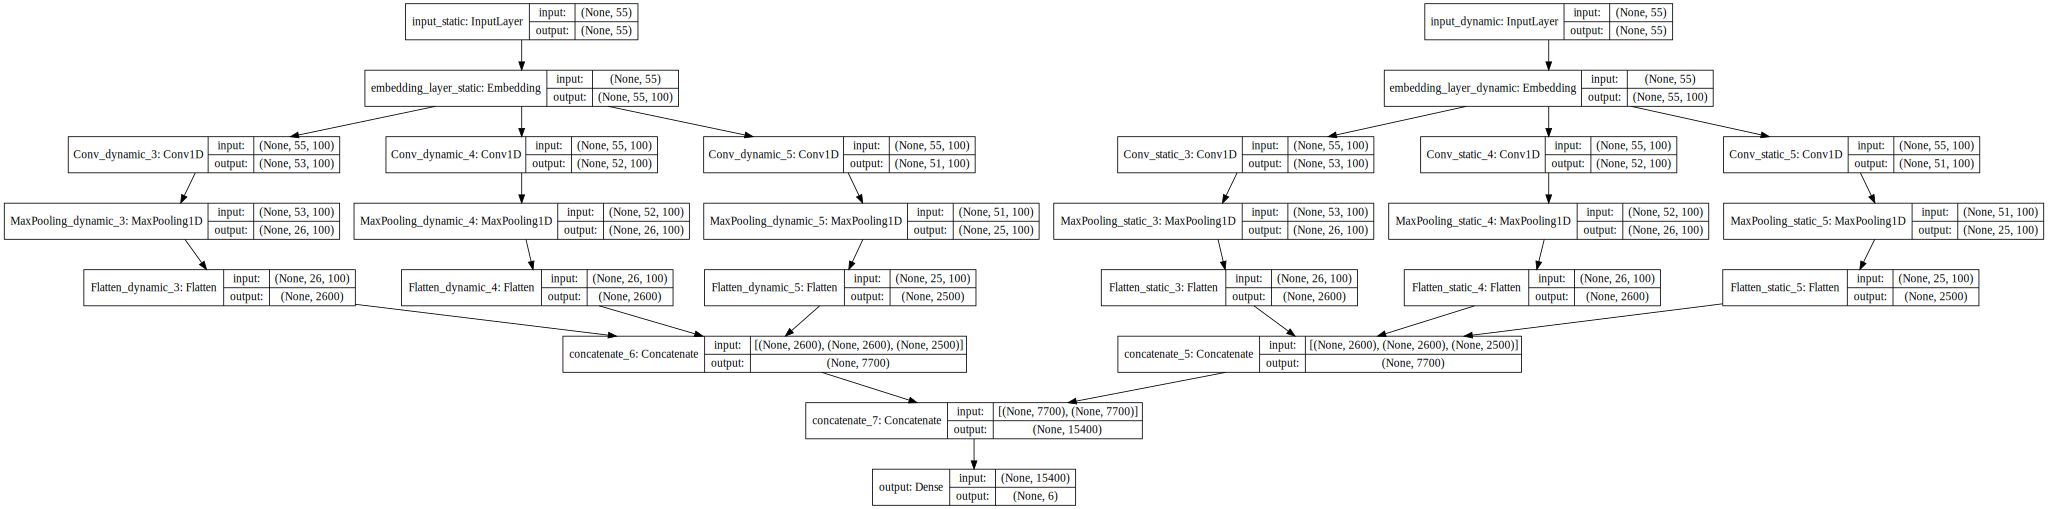

In [40]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))